<a href="https://www.kaggle.com/code/theongy/getting-started-maneuver-detection?scriptVersionId=120424735" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
"""Command line to load the data (valid only for this notebook)"""
import sys
package_paths = [
    '../input/hackathon2023/',
]

for pth in package_paths:
    sys.path.append(pth)
!cp -r '../input/maneuver-detection/' '/kaggle/working'

cp: ../input/maneuver-detection/: No such file or directory


In [2]:
import matplotlib.pyplot as plt

# Loading the dataset

A custom pytorch dataset is provided. It will parse the json dataset can be used with the pytorch loader. Since loading can sometimes take time, it is recommanded to execute the following cell at the beginning separately.

In [3]:
from ManeuverDetectionDataset import ManeuverDetectionDataset
dataset_path="/Users/FlorianLudwig/Supaero 2023/SDD_ML/hackaton/Hackathon_SDD_2023_commons/TRAIN_1_IRREGULAR_STEPS_V2.json"
train_dataset= ManeuverDetectionDataset(dataset_path,
                                        add_time_feature=False)



**********TRAIN DATASET *********
Validation/Train ratio: 0.1
Samples filtered? NO
Samples evenly spaced? False
path: /Users/FlorianLudwig/Supaero 2023/SDD_ML/hackaton/Hackathon_SDD_2023_commons/TRAIN_1_IRREGULAR_STEPS_V2.json
loading dataset. Ready in a minute!
TRAIN Dataset loaded. Size: 35762


As you can see, by default, the dataset is considered as a train dataset and 10% is not loaded for validation. To build the validation dataset, yo can do the same and you don't need to load again the json to save time ! **Beware : if you modify the code, you should take care to avoid to validate your model with the trained data!**

In [4]:
dataset= ManeuverDetectionDataset(dataset_path,dataset_type="VALIDATION",imported_dataset=train_dataset.dataset, 
                                  add_time_feature=True)



**********VALIDATION DATASET *********
Validation/Train ratio: 0.1
Samples filtered? NO
Samples evenly spaced? False
path: /Users/FlorianLudwig/Supaero 2023/SDD_ML/hackaton/Hackathon_SDD_2023_commons/TRAIN_1_IRREGULAR_STEPS_V2.json
VALIDATION Dataset loaded. Size: 3974


In [5]:
validation_dataset= ManeuverDetectionDataset(dataset_path,dataset_type="VALIDATION",
                                             imported_dataset=train_dataset.dataset,
                                            add_time_feature=False)



**********VALIDATION DATASET *********
Validation/Train ratio: 0.1
Samples filtered? NO
Samples evenly spaced? False
path: /Users/FlorianLudwig/Supaero 2023/SDD_ML/hackaton/Hackathon_SDD_2023_commons/TRAIN_1_IRREGULAR_STEPS_V2.json
VALIDATION Dataset loaded. Size: 3974


Finally, you can create your pytorch loader and have fun with your networks !

#### Train dataset :

In [77]:
from torch.utils.data import DataLoader
batch_size = 500

loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True) 
feature,is_maneuver,maneuver_dv,maneuver_time =next(iter(loader))
#print(f"features shape (batch size * nb of meas * nb of feature):{feature.shape}\nis maneuver: {is_maneuver.item()}\ndv (m/s): {maneuver_dv.item()}\nmaneuver date (seconds from the observation start): {maneuver_time.item()}")

#### Plots

In [7]:
inputs_klm = feature[47].numpy()
    #feature[x]; x --> numéro de batch
plt.scatter(inputs_klm[:,2],inputs_klm[:,0]); 
    # inputs [:,0] --> ascension droite
    # inputs[:,2] --> temps (48h)

IndexError: index 2 is out of bounds for axis 1 with size 2

In [ ]:
plt.scatter(inputs_klm[:,2],inputs_klm[:,1]); # inputs[:,1] --> déclinaison

IndexError: index 2 is out of bounds for axis 1 with size 2

#### NN

In [114]:
import torch
import torch.nn as nn

In [115]:
#fonction pour passer les scores en prédictions
def tri(outputs):
    outputs_np = outputs.detach().numpy()
    
    for i in range(len(outputs_np)):
        if outputs_np[i] > 0.5:
            outputs_np[i]=1
        elif outputs_np[i]<=0.5:
            outputs_np[i]=0

    return outputs_np.reshape(-1)

In [116]:
# Paramètres du modèle

# number of features (len of X cols)
input_dim = 2000
# number of nodes first hidden layer
hidden_nodes_layer_1 = 500
# number of nodes second hidden layer
hidden_nodes_layer_2 = 100

# number of classes (unique of y)
output_dim = 1
# learning rate
lr = 0.001

# Construction du modèle

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_nodes_layer_1)
        self.fc2 = nn.Linear(hidden_nodes_layer_1, hidden_nodes_layer_2)
        self.fc3 = nn.Linear(hidden_nodes_layer_2, output_dim)  
    
    def forward(self, x):
        x = torch.flatten(x, 1).float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
  
# Initialisiation du modèle
model = Network()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [117]:
from sklearn.metrics import accuracy_score

epochs = 100
losses = []
accuracies = []

# Entrainement du réseau

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(loader):
        inputs, labels , _ , _ = data
        
        # set optimizer to zero grad to remove previous epoch gradients
        optimizer.zero_grad()
        
        # forward propagation
        outputs = model.float()(inputs)        
        outputs = outputs.reshape(batch_size)                
        labels = labels.float()
        
        # loss        
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        
        # backward propagation
        loss.backward()
        
        # optimize
        optimizer.step()
        running_loss += loss.item()
                
        # accuracy 
        accuracies.append(accuracy_score(labels.numpy(),tri(outputs)))
                
      # display statistics
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.5f}')
    print(accuracy_score(labels.numpy(),tri(outputs)))


[1,    71] loss: 0.01718
0.824
[2,    71] loss: 0.01473
0.84
[3,    71] loss: 0.01446
0.844
[4,    71] loss: 0.01424
0.852
[5,    71] loss: 0.01409
0.858
[6,    71] loss: 0.01396
0.858
[7,    71] loss: 0.01384
0.858
[8,    71] loss: 0.01374
0.856
[9,    71] loss: 0.01362
0.858
[10,    71] loss: 0.01354
0.858
[11,    71] loss: 0.01345
0.856
[12,    71] loss: 0.01336
0.86
[13,    71] loss: 0.01333
0.862
[14,    71] loss: 0.01324
0.86
[15,    71] loss: 0.01316
0.86
[16,    71] loss: 0.01307
0.862
[17,    71] loss: 0.01299
0.862
[18,    71] loss: 0.01292
0.864
[19,    71] loss: 0.01292
0.862
[20,    71] loss: 0.01283
0.866
[21,    71] loss: 0.01283
0.862
[22,    71] loss: 0.01270
0.864
[23,    71] loss: 0.01268
0.864
[24,    71] loss: 0.01264
0.868
[25,    71] loss: 0.01265
0.868
[26,    71] loss: 0.01257
0.866
[27,    71] loss: 0.01247
0.87
[28,    71] loss: 0.01244
0.872
[29,    71] loss: 0.01236
0.868
[30,    71] loss: 0.01236
0.868
[31,    71] loss: 0.01233
0.87
[32,    71] loss: 0.012

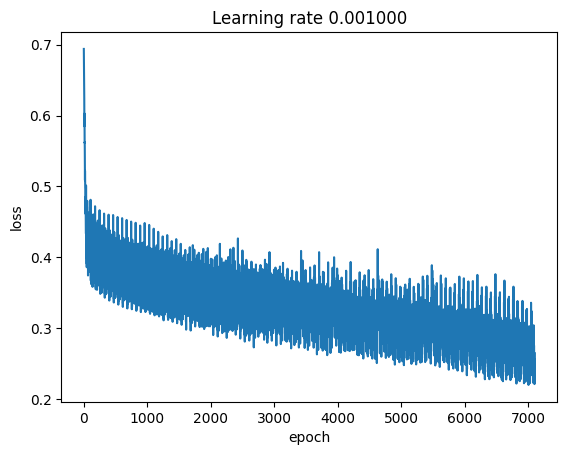

In [118]:
# Plot des loss
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(lr))
plt.show()

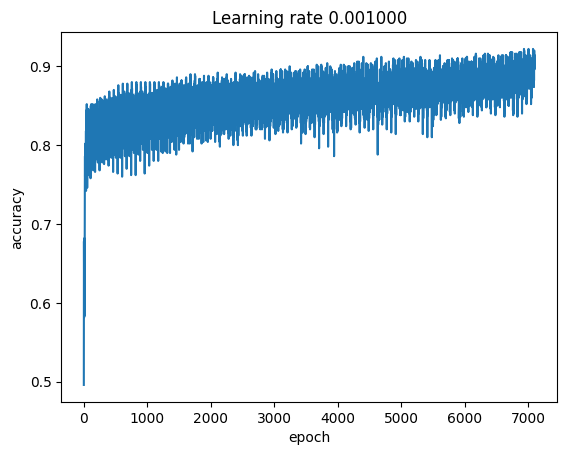

In [119]:
# Plot des accuracies
plt.plot(accuracies)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(lr))
plt.show()

In [120]:
from sklearn.metrics import classification_report

# chargement du validation dataset
valoader = DataLoader(validation_dataset, batch_size = len(validation_dataset) , drop_last = True)
valfeat,val_is_man,val_man_dv2,val_time_time = next(iter(valoader))

# test sur la validation dataset
for data in valoader:
        inputs, labels,_,_ = data
        # calculate output by running through the network
        outputs = model(inputs)
        #print(accuracy_score(labels.numpy(),tri(outputs)))

pred_maneuver = tri(outputs)
real_maneuver = val_is_man.numpy()

print(classification_report(real_maneuver, pred_maneuver))

              precision    recall  f1-score   support

           0       0.78      0.97      0.87      1995
           1       0.96      0.73      0.83      1979

    accuracy                           0.85      3974
   macro avg       0.87      0.85      0.85      3974
weighted avg       0.87      0.85      0.85      3974



In [121]:
PATH = './model_x.pth'
torch.save(model.state_dict(),PATH)

### TEST

To load the test dataset, you should set the dataset type to TEST:

In [139]:
test_dataset_path="/Users/FlorianLudwig/Supaero 2023/SDD_ML/hackaton/Hackathon_SDD_2023_commons/TEST_FILE_PUBLIC.json"
test_dataset= ManeuverDetectionDataset(test_dataset_path,dataset_type="TEST",add_time_feature=False)
test_loader = DataLoader(test_dataset, batch_size=1559, drop_last=True)
feature_test,is_maneuver,maneuver_dv,maneuver_time =next(iter(test_loader))
#print(f"features shape (batch size * nb of meas * nb of feature):{feature.shape}\nis maneuver: {is_maneuver.item()}\ndv (m/s): {maneuver_dv.item()}\nmaneuver date (seconds from the observation start): {maneuver_time.item()}")




**********TEST DATASET *********
Validation/Train ratio: 0.1
Samples filtered? NO
Samples evenly spaced? False
path: /Users/FlorianLudwig/Supaero 2023/SDD_ML/hackaton/Hackathon_SDD_2023_commons/TEST_FILE_PUBLIC.json
loading dataset. Ready in a minute!
TEST Dataset loaded. Size: 1559


In [140]:
pred_test_modelx = model(feature_test)

In [141]:
pred_test_ = tri(pred_test_modelx)

for evenly spaced dataset, you should use the option fixed_step : 


In [ ]:
evenly_spaced_dataset_path="/Users/FlorianLudwig/Supaero 2023/SDD_ML/hackaton/Hackathon_SDD_2023_commons/TRAIN_1_EVENLY_SPACED_V2.json"
evenly_spaced_dataset= ManeuverDetectionDataset(evenly_spaced_dataset_path,fixed_step=True)
evenly_spaced_loader = DataLoader(evenly_spaced_dataset, batch_size=1, drop_last=True)
feature,is_maneuver,maneuver_dv,maneuver_time =next(iter(evenly_spaced_loader))
print(f"features shape (batch size * nb of meas * nb of feature):{feature.shape}\nis maneuver: {is_maneuver.item()}\ndv (m/s): {maneuver_dv.item()}\nmaneuver date (seconds from the observation start): {maneuver_time.item()}")


#  It is time to submit !

When you think that your score is great you can submit ! To get started, you can generate your prediction file :

In [146]:
import pandas as pd

nx = pd.read_csv('prediction2.csv',delimiter=';')
mx = nx['date']
mx

0       0.365490
1       0.286856
2       0.527333
3       0.657202
4       0.662408
          ...   
1554    0.559766
1555    0.328250
1556    0.328180
1557    0.401010
1558    0.312405
Name: date, Length: 1559, dtype: float64

In [147]:
from SubmissionGenerator import create_submission
import numpy as np
#fake prediction
pred=np.zeros((len(test_dataset),3))
pred[:,0]=pred_test_ # classification
pred[:,1]=0.01*np.ones((len(test_dataset))) #dv
pred[:,2]=mx #time of the maneuver
create_submission(pred,"./prediction_test_3.csv")


Then, commit the file prediction.csv in the gitlab repository of your team. Don't forget to pull the repo before!
https://gitlab.com/TheoNguyen611/team-1-la-photomentalteam.git

https://gitlab.com/TheoNguyen611/team-2-avada-kedavra.git

https://gitlab.com/TheoNguyen611/team-3-frosty-gould.git

Wait a few moment and you should see your score appear in the leaderboard : http://34.163.85.74:5006/dashboard